# Analysis for recycle scenarios

This notebook provides analysis for all of the recycle scenarios that are included in 
Amanda Bachmann's disseration. Analysis of each scenario includes the uranium resoucre, 
SWU capacity and the amount of waste disposed. 

Scenarios are numbered as follows:
* Scenario 14: Limited reycle of all fuel, no energy growth
* Scenario 15: Limited recycle of non-TRISO fuel, no energy growth
* Scenario 16: Continuous recycle, no energy growth
* Scenario 17: Limited recycle of all fuel, 1% eergy growth
* Scenario 18: Limited recycle of non-TRISO fuel, 1% energy growth
* Scenario 19: Continuos recycle, 1% energy growth

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("../../../scripts")
import dataframe_analysis as dfa
import transition_metrics as tm

In [2]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.1975, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002,
         'SFR':0.1979}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'LWREnrichment', 'MMREnrichment', 'Xe100Enrichment',
                 'VOYGREnrichment','United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe100_UOX_Cooling',
                 'MMR_UOX_Cooling', 'VOYGR_UOX_Cooling',
                 'Xe100_MOX_Mixer', 'VOYGR_MOX_Mixer', 'MOXCoolingPool',
                 'SeparationsFacility', 'SeparationsInstitution', 'Sink_LWR_UOX', 'SFR']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR', 'SFR']

#Plotting orders
#plotting_order_nogrowth = ['s5','s2','s6','s7','s4','s3']
#plotting_order_1percent = ['s11','s08','s12','s13','s10','s09']
colors = {'s14':'tab:orange', 's15':'tab:purple','s16':'tab:brown',
                   's17':'tab:orange', 's18':'tab:purple','s19':'tab:brown'}
lines = {'s14':(0,(3,5,1)), 's15':(0,(5,3)),'s16':'-.',
                's17':(0,(3,5,1)), 's18':(0,(5,3)),'s19':'-.',}
labels = {'s14':'Scenario 14', 's15':'Scenario 15', 's16':'Scenario 16', 's17':'Scenario 17',
         's18':'Scenario 18', 's19':'Scenario 19'}
legend_order = [1, 5, 4, 0, 2, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481,
                    'SFR':0.9}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel',
                  'SFR':'spent_haleu'}
uox_commodity = {'LWR':'fresh_uox', 'MMR':'fresh_MMR_uox',
                   'Xe-100':'fresh_xe100_uox', 'VOYGR':'fresh_smr_uox', 
                   'SFR':'fresh_haleu'}
mox_commodity = {'Xe-100':'fresh_xe100_mox', 'VOYGR':'fresh_smr_mox',
                'SFR':'fresh_reprocessed'}

#Time period
time = np.linspace(2025, 2089, 65)

out_files = {'s14':'../outputs/scenario14.sqlite', 's15':'../outputs/scenario14.sqlite',
             's16':'../outputs/scenario16.sqlite', 's17':'../outputs/scenario14.sqlite',
             's18':'../outputs/scenario14.sqlite', 's19':'../outputs/scenario14.sqlite'}

## No growth demand

### Reactor numbers -- match up with once through scenarios

In [ ]:
reactors_nogrowth = {'s14':'','s16':''}
plt.figure(0)
for scenario in reactors_nogrowth:
    reactors_nogrowth[scenario] = tm.get_prototype_totals(out_files[scenario], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[scenario]['Year'][721:], reactors_nogrowth[scenario]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_recycle_reactors.pdf', bbox_inches='tight')

In [ ]:
for scenario in reactors_nogrowth:
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in {scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in {scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in {scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in {scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in {scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in {scenario}:', advrx_sum.iloc[-1])  

### Fuel Mass

In [ ]:
transactions_nogrowth = {'s14':'', 's15':'', 's16':''}

for key in transactions_nogrowth:
    scenario = key[:3]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files[scenario])

In [ ]:
# Divide up fuel mass by prototype
uranium_to_reactors = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
mox_to_reactors = {'s14_Xe-100':'', 's14_VOYGR':'', 
                   's15_Xe-100':'', 's15_VOYGR':'',
                   's16_SFR':''}

for key in uranium_to_reactors:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors[key] = dfa.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                       'fresh_uox',adv_rxs)
    else:
        uranium_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                       uox_commodity[reactor], reactor)
        uranium_to_reactors[key]['Quantity'] = uranium_to_reactors[key]['Quantity']*uranium_fractions[reactor]
    if reactor == 'Xe-100' or reactor == 'VOYGR' or reactor == 'SFR':
            mox_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario],
                                                     mox_commodity[reactor], reactor)

In [ ]:
for scenario in ['s14', 's15', 's16']:
    plt.figure(0)
    if scenario == 's16':
        plt.plot(uranium_to_reactors[scenario + '_SFR']['Year'],
                 uranium_to_reactors[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR uox'))
    else:
        for reactor in ['MMR', 'Xe-100','VOYGR']:
            plt.plot(uranium_to_reactors[scenario + '_' + reactor]['Year'],
                     uranium_to_reactors[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' uox'))
    plt.legend()

    plt.figure(1)
    if scenario == 's16':
        plt.plot(mox_to_reactors[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR U/TRU'))
    else:
        for reactor in ['Xe-100', 'VOYGR']:
            plt.plot(mox_to_reactors[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' mox'))
    plt.legend()

In [ ]:
for key in transactions_nogrowth:
    if key == 's16':
        AR_uranium = uranium_to_reactors[key + '_SFR'].copy()
    else:
        AR_uranium = uranium_to_reactors[key + '_MMR'].copy()
        for reactor in ['Xe-100', 'VOYGR']:
            AR_uranium['Quantity'] += uranium_to_reactors[key + '_' + reactor]['Quantity']
    averages = []
    counter = 721
    for ii in range(0, 65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter +=12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key], 
            color =colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    total_uranium = AR_uranium['Quantity'] + uranium_to_reactors[key + '_LWR']['Quantity']
    plt.figure(1)
    plt.plot(AR_uranium['Year'], total_uranium/1000, 
            label = labels[key], color = colors[key], linestyle=lines[key]) 
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()

    if key == 's16':
        total_mox = mox_to_reactors[key+'_SFR']['Quantity']
    else:
        total_mox = mox_to_reactors[key+'_Xe-100']['Quantity'] + mox_to_reactors[key+'_VOYGR']['Quantity']
    plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], total_mox[721:]/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')
    plt.legend()

In [ ]:
#Reporting uranium masses
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_mass = uranium_to_reactors[scenario+'_SFR']
    else:
        HALEU_mass = uranium_to_reactors[scenario+'_MMR'] + uranium_to_reactors[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    if scenario != 's16':
        AR_mass = HALEU_mass + uranium_to_reactors[scenario+'_VOYGR']
        print('Non-HALEU max in:',scenario, uranium_to_reactors[scenario+'_VOYGR'][721:]['Quantity'].max()/1000)
    else:
        AR_mass = HALEU_mass
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)
    print('Cumulative mass in', scenario, 'after 2025:',AR_mass[721:]['Quantity'].cumsum()[1499]/1000)

### Feed masses

In [ ]:
tails_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
feed_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
SWU_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}

for key in tails_nogrowth:
    reactor = key[4:]
    tails_nogrowth[key] = dfa.calculate_tails(uranium_to_reactors[key]['Quantity'],
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_nogrowth[key] = dfa.calculate_feed(uranium_to_reactors[key]['Quantity'],
                                  tails[key])
    SWU_nogrowth[key] = dfa.calculate_SWU(uranium_to_reactors[key]['Quantity'], assays[reactor],
                                tails[key], assays['tails'], feed[key], assays['feed'])

In [ ]:
# Feed uranium
for scenario in transactions_nogrowth:
    if scenario == 's16':
        AR_feed = feed_nogrowth[scenario + '_SFR'].copy()
    else:
        AR_feed = feed_nogrowth[scenario + '_MMR'].copy()
        for reactor in ['Xe-100','VOYGR']:
            AR_feed += feed[scenario + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    total_feed = AR_feed + feed_nogrowth[scenario + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'], total_feed/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'][721:], total_feed[721:].cumsum()/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()

In [ ]:
#Reporting feed masses
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_feed = feed_nogrowth[scenario+'_SFR']   
        AR_feed = HALEU_feed
    else:
        HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed[scenario+'_Xe-100']
        AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)
    print('AR Cumulative mass in', scenario, 'after 2025:', AR_feed[721:].cumsum()[1499]/1000)

### SWU

In [ ]:
for key in transactions_nogrowth:
    if key == 's16':
        AR_swu = SWU_nogrowth[key + '_SFR'].copy()
    else:
        AR_swu = SWU[key + '_MMR'].copy()
        for reactor in ['Xe-100','VOYGR']:
            AR_swu += SWU[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_swu[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=key,
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()
    
    total_swu = AR_swu + SWU[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors[key + '_LWR']['Year'], total_swu/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()

In [ ]:
#Reporting SWU Requirements
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_SWU = SWU_nogrowth[scenario+'_SFR']
        AR_SWU = HALEU_SWU
    else:
        HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
        AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    print('Average SWU in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum SWU in ', scenario, ':', AR_SWU[721:].max()/1000)

### Waste and SNF masses

In [ ]:
total_waste = {'s14':'', 's15':'', 's16':''} # all material sent to repository
mox_waste = {'s14':'', 's15':'', 's16':''} # spent MOX assemblies sent to repository
separations_waste = {'s14':'', 's15':'', 's16':''} # Separated waste, HLW
transition_waste = {'s14':'', 's15':'', 's16':''} # MOX and Separated waste (SNF + HLW)
snf_waste = {'s14':'', 's15':'', 's16':''}

for key in total_waste:
    total_waste[key] = dfa.transactions_to_prototype(transactions_nogrowth[key], 'Sink_HLW')
    LWR_waste = dfa.transactions_to_prototype(transactions_nogrowth[key], 'Sink_LWR_UOX')
    total_waste[key]['Quantity'] += LWR_waste['Quantity']

    separations_waste[key] = dfa.commodity_to_prototype(transactions_nogrowth[key], 'separated_waste', 'Sink_HLW')
    mox_waste[key] = dfa.commodity_to_prototype(transactions_nogrowth[key], 'cool_spent_mox', 'Sink_HLW')
    transition_waste[key] = separations_waste[key]['Quantity'] + mox_waste[key]['Quantity']
    snf_waste[key] = mox_waste[key]['Quantity'] + LWR_waste['Quantity']
        
    plt.figure(0)
    plt.plot(total_waste[key]['Year'], total_waste[key]['Quantity']/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()
    
    #plt.figure(1)
    #plt.plot(waste[key]['Year'], waste[key]['Quantity'].cumsum()/1000, label=labels[key],
    #        color=colors[key], linestyle=lines[key])
    #plt.xlabel('Year')
    #plt.ylabel('Waste mass (MT)')
    #plt.legend()

    plt.figure(2)
    plt.plot(mox_waste[key]['Year'][721:], mox_waste[key]['Quantity'][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()

    plt.figure(3)
    plt.plot(separations_waste[key]['Year'][721:], separations_waste[key]['Quantity'][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()
    
    plt.figure(4)
    plt.plot(separations_waste[key]['Year'][721:], transition_waste[key][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()

    plt.figure(5)
    plt.plot(separations_waste[key]['Year'][721:], transition_waste[key][721:].cumsum()/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()
    
    plt.figure(6)
    plt.plot(separations_waste[key]['Year'], snf_waste[key], label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()


In [ ]:
#Reporting waste masses
for scenario in transactions_nogrowth:
    print('Average MOX waste in', scenario, 'after 2025:', mox_waste[key]['Quantity'][721:].mean()/1000)
    print('Average separations waste in', scenario, 'after 2025:', separations_waste[key]['Quantity'][721:].mean()/1000)
    print('Average transition waste in', scenario, 'after 2025:', transition_waste[key][721:].mean()/1000)
    print('Average SNF waste in', scenario, 'after 2025:', snf_waste[key][721:].mean()/1000)
    print('Maximum  in', scenario, ':', transition_waste[key][721:].max()/1000)
    print('Cumulative  in', scenario, ':', transition_waste[key][721:].cumsum()[1499]/1000)

### Separated Pu

In [3]:
sep_pu = {'s14':'', 's15':'', 's16':''}
transactions_senders = {'s14':'', 's15':'', 's16':''}
for key in sep_pu:
    transactions_senders[key] = tm.add_sender_prototype(out_files[key])
    sep_pu[key] = dfa.commodity_from_prototype(transactions_senders[key],
                                               'separated_fissile',
                                               'SeparationsFacility')

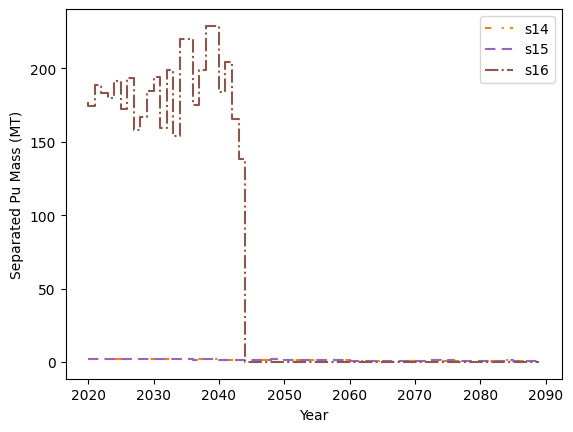

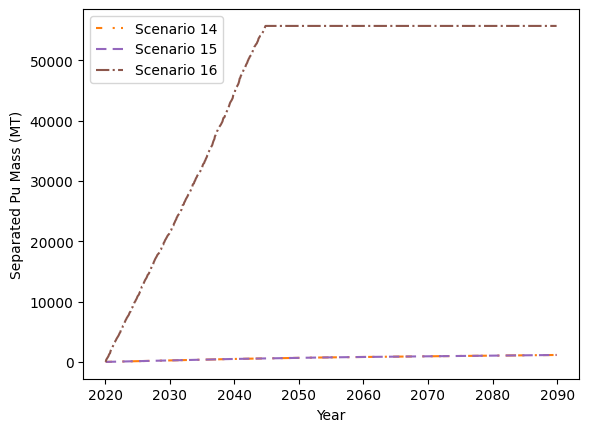

In [5]:
for key in transactions_senders:
    counter = 661
    averages = []
    for ii in range(0, 70):
        year_data = sep_pu[key]['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2020, 2089, 70), averages, label=key,
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(sep_pu[key]['Year'][661:], sep_pu[key]['Quantity'][661:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()

In [7]:
#reporting seaparated Pu masses
for scenario in transactions_senders:
    #waste_mass = waste[scenario]['Quantity']
    #print('Average MOX waste in', scenario, 'after 2025:', mox_waste[key]['Quantity'][721:].mean()/1000)
    #print('Average separations waste in', scenario, 'after 2025:', separations_waste[key]['Quantity'][721:].mean()/1000)
    print('Average transition waste in', scenario, 'after 2020:', sep_pu[key]['Quantity'][721:].mean()/1000)
    print('Maximum  Sep Pu in', scenario, ':', sep_pu[key]['Quantity'][721:].max()/1000)
    print('Cumulative Sep Pu in', scenario, ':', sep_pu[key]['Quantity'][721:].cumsum()[1499]/1000)

Average transition waste in s14 after 2020: 57.566115662180316
Maximum  Sep Pu in s14 : 454.3196487699934
Cumulative Sep Pu in s14 : 44844.00410083847
Average transition waste in s15 after 2020: 57.566115662180316
Maximum  Sep Pu in s15 : 454.3196487699934
Cumulative Sep Pu in s15 : 44844.00410083847
Average transition waste in s16 after 2020: 57.566115662180316
Maximum  Sep Pu in s16 : 454.3196487699934
Cumulative Sep Pu in s16 : 44844.00410083847


## 1% growth scenarios

### Fuel Mass

In [ ]:
transactions_1percent = {'s17':'', 's18':'', 's19':''}
total_fuel_1percent = {'s17':'', 's18':'', 's19':''}

for scenario in ['s17']:
    transactions_1percent[scenario] = oup.add_receiver_prototype(out_files[scenario])

In [ ]:
# Divide up fuel mass by prototype
uranium_to_reactors_1percent = {'s17_MMR':'', 's17_Xe-100':'', 's17_VOYGR':'', 's17_LWR':''}
mox_to_reactors_1percent = {'s17_Xe-100':'', 's17_VOYGR':''}

for key in uranium_to_reactors:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = dfa.commodity_to_LWR(transactions_1percent[scenario], 
                                                       'fresh_uox',adv_rxs)
    else:
        uranium_to_reactors_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[scenario], 
                                                       uox_commodity[reactor], reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]
    if reactor == 'Xe-100' or reactor == 'VOYGR':
            mox_to_reactors_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[scenario],
                                                     mox_commodity[reactor], reactor)


In [ ]:
for scenario in ['s17']:
    plt.figure()
    for reactor in adv_rxs:
        plt.plot(uranium_to_reactors_1percent[scenario + '_' + reactor]['Year'],
                 uranium_to_reactors_1percent[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' uox'))
    plt.legend()
    
    plt.figure()
    for reactor in ['Xe-100','VOYGR']:
        plt.plot(mox_to_reactors_1percent[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' mox'))
    plt.legend()

In [ ]:
for key in ['s17']:
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key + '_' + reactor]['Quantity']
    averages = []
    counter = 721
    for ii in range(0, 65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter +=12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key], 
            color =colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    total_uranium = AR_uranium['Quantity'] + uranium_to_reactors_1percent[key + '_LWR']['Quantity']
    plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_uranium/1000, 
            label = labels[key], color = colors[key], linestyle=lines[key]) 
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    plt.figure()
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    total_mox = mox_to_reactors_1percent[key+'_Xe-100']['Quantity'] + mox_to_reactors_1percent[key+'_Xe-100']['Quantity']
    plt.figure()
    plt.plot(mox_to_reactors_1percent[key+'_Xe-100']['Year'], total_mox,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')
    plt.legend()

### Enrichment

In [ ]:
tails_1percent = {'s17_MMR':'', 's17_VOYGR':'', 's17_Xe-100':'', 's17_LWR':''}
feed_1percent = {'s17_MMR':'', 's17_VOYGR':'', 's17_Xe-100':'', 's17_LWR':''}
SWU_1percent = {'s17_MMR':'', 's17_VOYGR':'', 's17_Xe-100':'', 's17_LWR':''}

for key in tails_1percent:
    reactor = key[4:]
    tails_1percent[key] = dfa.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'],
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_1percent[key] = dfa.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'],
                                  tails_1percent[key])
    SWU_1percent[key] = dfa.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'], assays[reactor],
                                tails_1percent[key], assays['tails'], feed_1percent[key], assays['feed'])

In [ ]:
# feed U
for key in ['s17']:
    AR_feed = feed_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    total_feed = AR_feed + feed_1percent[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_feed/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], total_feed[721:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()

In [ ]:
# SWU 
for key in ['s17']:
    AR_swu = SWU_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_swu += SWU_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_swu[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()
    
    total_swu = AR_swu + SWU_1percent[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_swu/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()

### Waste mass -- disposed of in HLW Sink

In [ ]:
waste_1percent = {'s17':''}
for key in waste_1percent:
    waste_1percent[key] = dfa.transactions_to_prototype(transactions_1percent[key], 'Sink_HLW')
    LWR_waste = dfa.transactions_to_prototype(transactions_1percent[key], 'Sink_LWR_UOX')
    waste_1percent[key]['Quantity'] += LWR_waste['Quantity']
    plt.figure(0)
    plt.plot(waste_1percent[key]['Year'], waste_1percent[key]['Quantity']/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()
    
    plt.figure(1)
    plt.plot(waste_1percent[key]['Year'], waste_1percent[key]['Quantity'].cumsum()/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()

### Separated Pu

In [ ]:
sep_pu_1percent = {'s17':''}

for key in sep_pu_1percent:
    transactions = oup.add_sender_prototype(out_files[key])
    sep_pu_1percent[key] = dfa.commodity_from_prototype(transactions,
                                               'separated_fissile',
                                               'SeparationsFacility')

In [ ]:
for key in ['s17']:
    counter = 661
    averages = []
    for ii in range(0, 70):
        year_data = sep_pu_1percent[key]['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2020, 2089, 70), averages, label=key,
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(sep_pu_1percent[key]['Year'][661:], sep_pu_1percent[key]['Quantity'][661:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()